### Warning

The parameters are estimated to a high precision.
* Saving to Excel causes floating point errors
* Thus, loading these parameters and building tree will not exactly price calibrated bonds

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

## Parameters

In [3]:
DATE = '2023-04-21'
FREQ = 4
Tmat = 5

SAVEDATA = True

## Load Caps or Set Adhoc Vol

/Users/markhendricks/Projects/finm-fiderivs-2023/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Axes: >

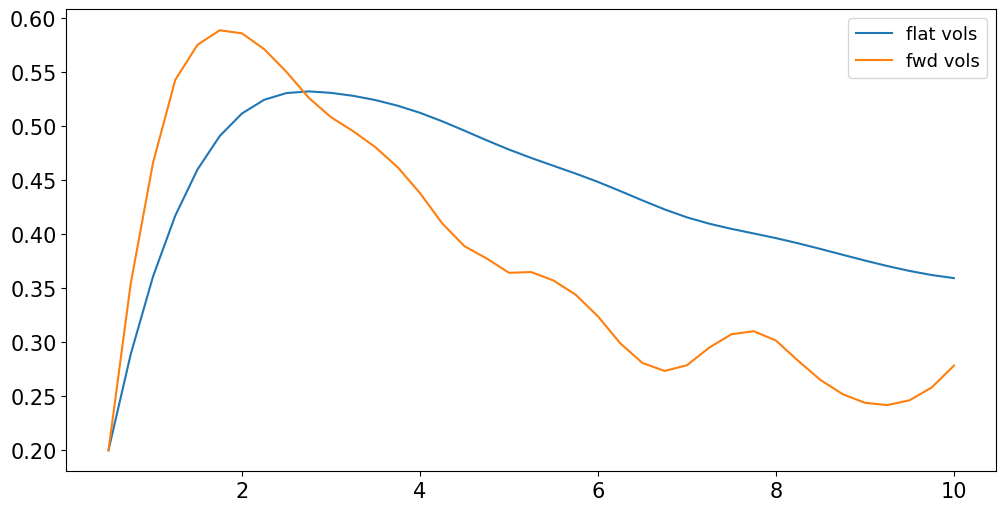

In [9]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}_freq_{FREQ}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

curves.index = curves.index.to_numpy().round(6)

# capcurves = flat_to_forward_vol(curves)
# capcurves[['flat vols','fwd vols']].plot()

capcurves = flat_to_forward_vol_rev(curves['flat vols'],curves['swap rates'],curves['forwards'],curves['discounts'],freq=FREQ)
capcurves[['flat vols','fwd vols']].iloc[:-1,:].plot()

### Build Rate Tree

In [5]:
capcurves

,flat vols,caplet prices,fwd vols,cap prices
0.25,NaN,NaN,NaN,NaN
0.50,0.312855,0.079464,0.312855,0.079464
0.75,0.336921,0.109894,0.383569,0.189357
1.00,0.360987,0.140995,0.477872,0.330352
1.25,0.416510,0.207641,0.758475,0.537993
1.50,0.458587,0.233880,0.833913,0.771874
1.75,0.489001,0.247125,0.879065,1.018999
2.00,0.509541,0.255744,0.809991,1.274743
2.25,0.521990,0.251910,0.832651,1.526653
2.50,0.528137,0.249131,0.772926,1.775784


In [6]:
quotes = curves['discounts']*100

sigmas = capcurves['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]
sigmas.index = sigmas.index.to_numpy().round(6)

tsteps = round(Tmat * FREQ)

theta, ratetree = estimate_theta(sigmas.iloc[:tsteps+1],quotes.iloc[:tsteps+1])

In [7]:
discounts = quotes.loc[:Tmat]/100
#discounts.index = discounts.index.to_numpy().round(6)
discounts.name = 'discount'

params = pd.concat([discounts,sigmas,theta],axis=1,join='inner')
params.index.name = 'maturity'
params.rename(columns={'fwd vols':'fwd vol'},inplace=True)

### Save Data

In [8]:
if SAVEDATA:
    outfile = f'../build_data/bdt_params_freq{FREQ}_{DATE}.xlsx'
    with pd.ExcelWriter(outfile) as writer:  
        params.to_excel(writer, sheet_name= 'parameters', index=True)